In [ ]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [7]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [8]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']


# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

In [9]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [10]:
df = pd.read_csv('uae.csv')
spectra = df.iloc[:, 7:2158].copy()

## Savgol smoothing (order 1 and order 2)

In [11]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')           
        
# clipping out the initial 50 noisy wavelengths -------------- 
for i in window_lengths:
    spec1[i] = spec1[i].iloc[:, 150:2001]  

    
spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')
        
# clipping out the initial 50 noisy wavelengths --------------            
for i in window_lengths:
    spec2[i] = spec2[i].iloc[:, 150:2001] 

# clipped original spectra (initial 50 noisy wavelengths removed) ------------------------------------    

clipped_spectra = spec1[1]

# minimum and maximum iloc locations (c_min, c_max) and loc locations (loc_min, loc_max)------------
c_min = 0
c_max = 1851

loc_min = 500
loc_max = 2350

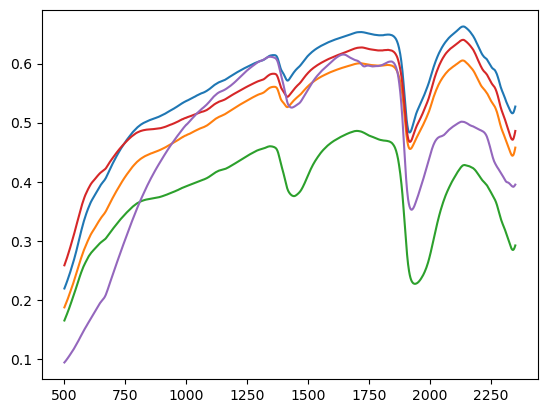

In [12]:
for i in range (0,5,1):
    clipped_spectra.iloc[i,:].plot()

## First Order Derivative

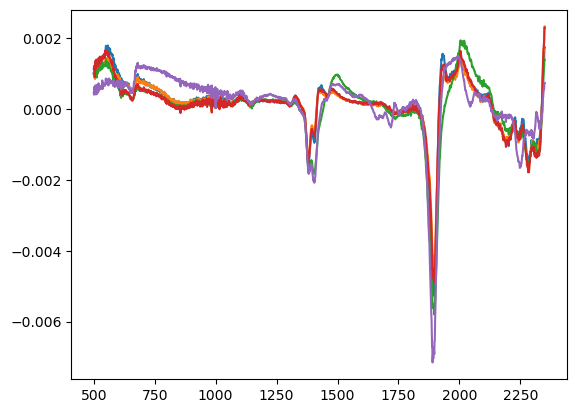

In [13]:
fod_spec = fod(spec2[51])

for i in range (0,5,1):
    fod_spec.iloc[i,:].plot()


In [14]:
fod1 = {}
for i in window_lengths:
    fod1[i] = filt_sg(fod_spec, i, 'sg1')
    
fod2 = {}
for i in window_lengths:
    fod2[i] = filt_sg(fod_spec, i, 'sg2') 

In [15]:
# smoothing the clipped fod spectra using sgsmooth

smth_fod = sgsmooth (fod_spec, 3)

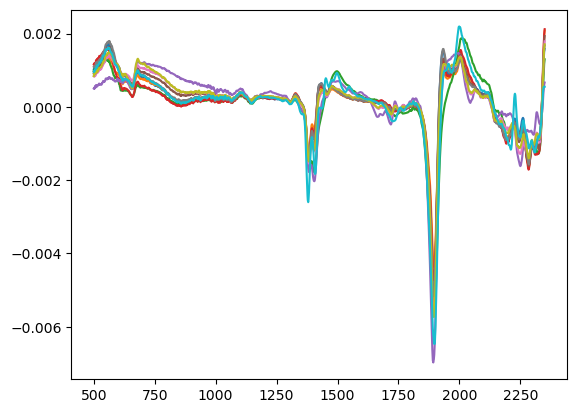

In [16]:
for i in range (0,10,1):
    smth_fod.iloc[i,:].plot()

## Continuum Removal

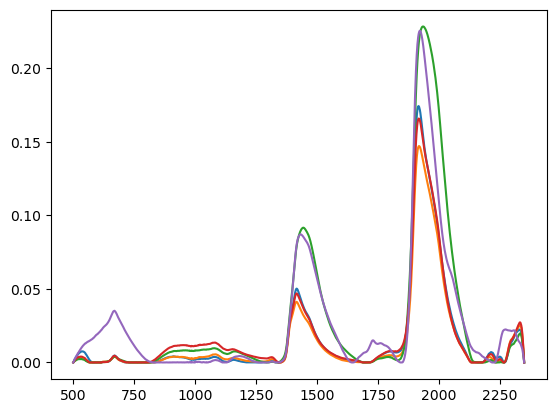

In [17]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,5,1):
    cr_spec.iloc[i,:].plot()
    

In [18]:
cr1 = {}
for i in window_lengths:
    cr1[i] = filt_sg(cr_spec, i, 'sg1')
    
cr2 = {}
for i in window_lengths:
    cr2[i] = filt_sg(cr_spec, i, 'sg2')  
 

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [19]:
sampled_spec = {}
for w in nbands_sampling:
    sampled_spec[w] = resample_spectra (spec2[51], w)

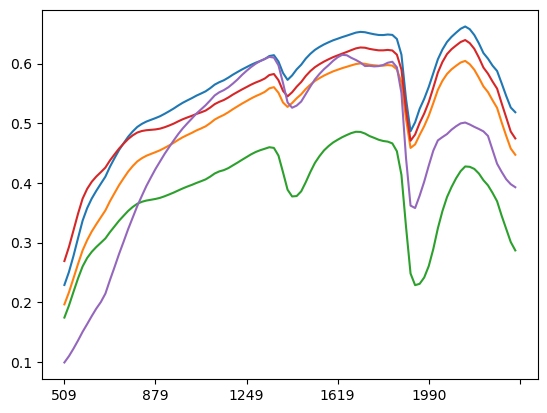

In [20]:
for i in range (0,5,1):
    sampled_spec[100].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [21]:
sampled_cr = {}
for w in nbands_sampling:
    sampled_cr[w] = resample_spectra (cr_spec, w)

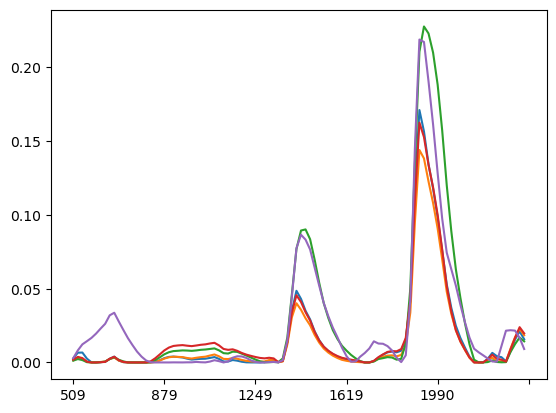

In [22]:
for i in range (0,5,1):
    sampled_cr[100].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [23]:
sampled_fod = {}
for w in nbands_sampling:
    sampled_fod[w] = resample_spectra (smth_fod, w)

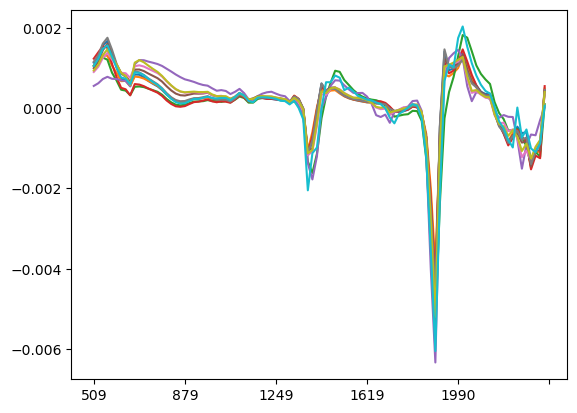

In [24]:
for i in range (0,10,1):
    sampled_fod[100].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [25]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = smth_fod.iloc[sample,:]*100
        
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 293,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=146, description='sample', max=293), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

# Step 1b: Target  Preprocessing (Outliers removal and Normalization)

In [26]:
df = pd.read_csv('uae.csv')
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 


def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


## Correlation between wavelengths and Targets

In [27]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(smth_fod, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.7, 0.7])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)



interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [28]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.20

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spec2[51].copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spec2[51].copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For sand :test size = 0.2 	 min bin error= 21.25 	 at randome state = 18
For silt :test size = 0.2 	 min bin error= 18.75 	 at randome state = 13
For clay :test size = 0.2 	 min bin error= 31.25 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 13.75 	 at randome state = 15
After Normalization:
For sand :test size = 0.2 	 min bin error= 33.75 	 at randome state = 23
For silt :test size = 0.2 	 min bin error= 33.75 	 at randome state = 0
For clay :test size = 0.2 	 min bin error= 31.25 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 23.75 	 at randome state = 13


In [29]:
# ## Plotting the Distribution of Train and Test Output Data  --------------

##### Plot train test split fr normalised and without normalised data using ipywidgets for all  the 4 targets---------
# plt.style.use(['science','notebook','grid'])

# def train_test_plot (target):

#     fig, ax = plt.subplots(1,2, figsize=(18,7))

#     i = target_names.index(target)
    
#     for i in range (0, len(target)):
#         minimum = np.min(target[i])
#         maximum = np.max(target[i])
    
#     bins = np.linspace(minimum, maximum, 8)
    
#     for i in range (0, len(target)):
        
#         if preprocessing == 'none':
#             ax[0].hist([y_train, y_test], bins , label=['Train', 'Test'], density=True, color = ['mediumaquamarine','lightcoral'])
#             ax[0].legend(loc='upper right', fontsize =8)
#             ax[0].set_xlabel('Without Normalisation'+target+'content',fontsize =12)
#             ax[0].set_ylabel('Normalised frequency',fontsize =12)
#             ax[0].tick_params(axis='both', labelsize=8)
        
#         else:
#             ax[1].hist([y_train, y_test], bins , label=['Train', 'Test'], density=True, color = ['mediumaquamarine','lightcoral'])
#             ax[1].legend(loc='upper right', fontsize =8)
#             ax[1].set_xlabel('Normalised '+target_names[i]+' content',fontsize =12)
#             ax[1].set_ylabel('Normalised frequency',fontsize =12)
#             ax[1].tick_params(axis='both', labelsize=8)
       
#      #elif  target == 'silt' and preprocessing == 'none':
# #         ax[0].legend(loc='upper right', fontsize =8)
# #         ax[0].set_xlabel('Without Normalisation SILT content',fontsize =12)
# #         ax[0].set_ylabel('Normalised frequency',fontsize =12)
# #         ax[0].tick_params(axis='both', labelsize=8)
        
# #         else:
# #             ax[1].legend(loc='upper right', fontsize =8)
# #             ax[1].set_xlabel('Normalised SILT content',fontsize =12)
# #             ax[1].set_ylabel('Normalised frequency',fontsize =12)
# #             ax[1].tick_params(axis='both', labelsize=8)
            
# #     elif  target == 'clay' and preprocessing == 'none':
# #         ax[0].legend(loc='upper right', fontsize =8)
# #         ax[0].set_xlabel('Without Normalisation CLAY content',fontsize =12)
# #         ax[0].set_ylabel('Normalised frequency',fontsize =12)
# #         ax[0].tick_params(axis='both', labelsize=8)
        
# #         else:
# #             ax[1].legend(loc='upper right', fontsize =8)
# #             ax[1].set_xlabel('Normalised CLAY content',fontsize =12)
# #             ax[1].set_ylabel('Normalised frequency',fontsize =12)
# #             ax[1].tick_params(axis='both', labelsize=8)
              
     
# #      else:
# #         if preprocessing == 'none':
# #             ax[0].legend(loc='upper right', fontsize =8)
# #             ax[0].set_xlabel('Without Normalisation TOC content',fontsize =12)
# #             ax[0].set_ylabel('Normalised frequency',fontsize =12)
# #             ax[0].tick_params(axis='both', labelsize=8)
        
# #         else:
# #             ax[1].legend(loc='upper right', fontsize =8)
# #             ax[1].set_xlabel('Normalised TOC content',fontsize =12)
# #             ax[1].set_ylabel('Normalised frequency',fontsize =12)
# #             ax[1].tick_params(axis='both', labelsize=8)
            
#     fig.suptitle('Train Test Distribution of Data', x = 0.5 ,y = .95, fontsize = 20)

#     plt.show()
       
# ipywidgets.interact(train_test_plot, target = ['sand', 'silt','clay', 'TOC'])



# Step 3: Parameters for Best Model Fit 

## PLSR

In [30]:

from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
    r2L = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = iqrp(y_pred, y_test)
        r2_test = r2_score(y_test, y_pred)         
        #rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
               
        iqrpL.append(iqrp_test)
        r2L.append(r2_test)
#         rpdL.append(rpd_test)
        
        
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
    R2 = max(r2L)     
    n_r2 = r2L.index(R2)+1    

    #     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
    #print('IQRP :', IQRP,  'R2 :', R2,  '>>> n_comp: ', n_iqrp)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [49]:
import os
os.system('say "your program has finished"')
import time

In [50]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [152]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    
                    #---- following case : either sampling or decision tree methods--
                    #---- in this case select appropriate sampled spectrum -------
                    if n!=0 or m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                        #------ case: sampling required-----------------------
                        Y = tree[t][tp][n][p]
                        
                        #------ setting spec to appropriate sampled spectra----
                        if p == 'none':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_spec[n]
                        
                        elif p == 'fod':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_fod[n]
                                
                        else:  
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_cr[n]
                        
                        #---- target selection and normalization ---
                        if tp == 'none':
                            y = T[target_names.index(t)]
                            rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                        else:
                            y = NT[target_names.index(t)]
                            rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                            #print('one more target set')
                            
                        #---- performing train-test split----------------------
                        X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                        
                        
                        #------INITIATING the appropriate models-----------------------------------------------
                        #----- PLSR: best parameters, fitting, and prediction
                        if m == 'plsr':
                            n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                            Y['n_comp'] = n_com
                            Model = PLSRegression(n_components=n_com, scale=True)
                        #----- MULTILINEAR:  fitting, and prediction---------- 
                        elif m == 'mult':
                            Model = linear_model.LinearRegression()    
                        #----- RANDOM_FOREST:   fitting, and prediction---------- 
                        elif m == 'randomforest': 
                            Model = RandomForestRegressor(random_state= 20)    
                        #----- CUBIST REGRESSION:    fitting and prediction---------
                        elif m == 'cubist':
                            Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)    
                        #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                        elif m == 'svr': 
                            Model = SVR()
                        #------ RIDGE REGRESSION: fitting and prediction-----------      
                        elif m == 'ridge': 
                            Model = KernelRidge()
                        #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                        else: 
                            Model = GradientBoostingRegressor()                         
                        
                        Model.fit(X_train, y_train)
                        y_pred = Model.predict(X_test)
                        yhat_pred = Model.predict(X_train)
                                
                        Y['test'] = y_test
                        Y['testP'] = y_pred
                        Y['train'] = y_train
                        Y['trainP'] = yhat_pred
                        Y['iqrp_test'] = iqrp(y_pred, y_test)
                        Y['r2_test'] = r2_score(y_test, y_pred)
                        Y['rpd_test'] = rpd(y_pred, y_test)
                        Y['rmse_test'] = np.sqrt(mean_squared_error(y_pred, y_test))
                                              
                                                                                             
                    #---- following case: no sampling needed and model is not tree based methods e.g. randomforest ---    
                    else: 
                        for sg in sg_filters:
                            tree[t][tp][n][p][sg] ={}
                            for w in window_lengths:
                                tree[t][tp][n][p][sg][w]={}
                                Y = tree[t][tp][n][p][sg][w]
                                
                                # -- optimal train test split----------------------------------------
                            
                                # -- deciding the smoothed spectra in present branch ---
                                if sg == 'sg1':
                                    spec = spec1[w]
                                else:
                                    spec = spec2[w]
                                
                                # -- preprocessing the spectra ------
                    
                                #--- no preprocessing ---------------
                                if p == 'none':
                                    spec = spec
                                
                                #--- first order derivative + smoothing------    
                                elif p == 'fod':
                                    if sg == 'sg1':
                                        spec = fod1[w]
                                    else:
                                        spec = fod2[w]
                                    #print('fod for one more case')
                                
                                #--- continuum removal + smoothing---------    
                                else: 
                                    if sg == 'sg1':
                                        spec = cr1[w]
                                    else:
                                        spec = cr2[w]
                                    #print('cr for one more case')
                            
                                
                                #---- target selection and normalization ---
                                if tp == 'none':
                                    y = T[target_names.index(t)]
                                    rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                                else:
                                    y = NT[target_names.index(t)]
                                    rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                                    #print('one more target set')
                            
                                #---- performing train-test split----------------------
                                X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                                
                                #----- PLSR: best parameters, fitting, and prediction
                                if m == 'plsr':
                                    n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                                    Y['n_comp'] = n_com
                                    Model = PLSRegression(n_components=n_com, scale=True)
                                #----- MULTILINEAR:  fitting, and prediction---------- 
                                elif m == 'mult':
                                    Model = linear_model.LinearRegression()    
                                    
                                #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                                elif m == 'svr': 
                                    Model = SVR(kernel = 'poly', degree =3, C = 0.0001)    
                                    
                                #--------- RIDGE REGRESSION: fitting and prediction------------------
                                else: 
                                    Model = KernelRidge()                                        
                                
                                Model.fit(X_train, y_train)
                                y_pred = Model.predict(X_test)
                                yhat_pred = Model.predict(X_train)
                                
                                Y['test'] = y_test
                                Y['testP'] = y_pred
                                Y['train'] = y_train
                                Y['trainP'] = yhat_pred
                                Y['iqrp_test'] = iqrp(y_pred, y_test)
                                Y['r2_test'] = r2_score(y_test, y_pred)
                                Y['rpd_test'] = rpd(y_pred, y_test)
                                Y['rmse_test'] = np.sqrt(mean_squared_error(y_pred, y_test))
                                
                                     
    
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Mtree initialisation (do not run below code every time)

In [93]:
Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [120]:
Mtree['plsr'] = build_tree_for ('plsr')

tree for plsr running on sand
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 1
before updating n_comp
kept n_comp 1
before u

before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 1
before updating n_comp
kept n_comp 1
before updating n_comp
kept n_comp 1
before updating n_comp
kept n_comp 1
b

before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updati

before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
after updating n_comp
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating n_comp
kept n_comp 4
before updating 

### Multiple Linear Regression Branch

In [153]:
Mtree['mult'] = build_tree_for ('mult')

tree for: mult ------> running on: sand
tree for: mult ------> running on: silt
tree for: mult ------> running on: clay
tree for: mult ------> running on: TOC
End time - Start time = 44.405115365982056



### Random Forest Branch

In [96]:
Mtree['randomforest'] = build_tree_for ('randomforest')

tree for randomforest running on sand
tree for randomforest running on silt
tree for randomforest running on clay
tree for randomforest running on TOC
End time - Start time = 416.72732949256897


### SVM Branch

In [97]:
Mtree['svr'] = build_tree_for ('svr')

tree for svr running on sand
tree for svr running on silt
tree for svr running on clay
tree for svr running on TOC
End time - Start time = 65.59491395950317


### GBRT Branch

In [98]:
Mtree['gbrt'] = build_tree_for ('gbrt')

tree for gbrt running on sand
tree for gbrt running on silt
tree for gbrt running on clay
tree for gbrt running on TOC
End time - Start time = 244.625981092453


### Ridge Regression Branch

In [99]:
Mtree['ridge'] = build_tree_for ('ridge')

tree for ridge running on sand
tree for ridge running on silt
tree for ridge running on clay
tree for ridge running on TOC
End time - Start time = 30.412766933441162


### Cubist Branch

In [100]:
Mtree['cubist'] = build_tree_for ('cubist')

tree for cubist running on sand


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on silt


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on clay


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for cubist running on TOC


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

End time - Start time = 146.30562472343445


## Best of all worlds

In [126]:
def best_model_parameters (Mtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    best_n_comp = 'NA'
    
    if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    Y = Mtree[m][t][tp][n][p]
                    
                    if scorer == 'iqrp':
                        cur_score = Y['iqrp_test']
                    elif scorer == 'rpd':
                        cur_score = Y['rpd_test']
                    elif scorer == 'r2':
                        cur_score = Y['r2_test']  
                    else:
                        cur_score = Y['rmse_test']  
                        
                    if cur_score > best_score:
                        best_score = cur_score
                        best_tp = tp
                        best_n = n
                        best_p = p
                        
                            
    else:
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    for sg in sg_filters:
                        for w in window_lengths:
                            if n == 0:
                                Y = Mtree[m][t][tp][n][p][sg][w]
                            else:
                                Y = Mtree[m][t][tp][n][p]
                                
                            if scorer == 'iqrp':
                                cur_score = Y['iqrp_test']
                            elif scorer == 'rpd':
                                cur_score = Y['rpd_test']
                            elif scorer == 'r2':
                                cur_score = Y['r2_test']  
                            else:
                                cur_score = Y['rmse_test']      
                                
                            if cur_score > best_score:
                                best_score = cur_score
                                best_tp = tp
                                best_n = n
                                best_p = p
                                if m == 'plsr':
                                    best_n_comp = Y['n_comp']
                                    
                                    
    param_list = [scorer, np.round(best_score,2), 'pSpec:', best_p, 'bands:', best_n, 'pTar:', best_tp, 'best_n_comp: ', best_n_comp]                                 
    return (param_list)                                
    

In [127]:
param_list = best_model_parameters (Mtree, 'sand', 'randomforest', 'r2')
print(param_list)

['r2', 0.53, 'pSpec:', 'fod', 'bands:', 0, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [128]:
param_list = best_model_parameters (Mtree, 'sand', 'plsr', 'r2')
print(param_list)

['r2', 0.54, 'pSpec:', 'continuum', 'bands:', 500, 'pTar:', 'minmax', 'best_n_comp: ', 4]


In [136]:
param_list = best_model_parameters (Mtree, 'sand', 'plsr', 'iqrp')
print(param_list)

['iqrp', 1.97, 'pSpec:', 'continuum', 'bands:', 500, 'pTar:', 'minmax', 'best_n_comp: ', 4]


In [130]:
param_list = best_model_parameters (Mtree, 'sand', 'cubist','r2')
print(param_list)

['r2', 0.54, 'pSpec:', 'none', 'bands:', 200, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [138]:
param_list = best_model_parameters (Mtree, 'sand', 'cubist', 'iqrp')
print(param_list)

['iqrp', 1.98, 'pSpec:', 'none', 'bands:', 200, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [132]:
param_list = best_model_parameters (Mtree, 'sand', 'mult','r2')
print(param_list)

['r2', 0.52, 'pSpec:', 'continuum', 'bands:', 20, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [133]:
param_list = best_model_parameters (Mtree, 'sand', 'ridge','r2')
print(param_list)

['r2', 0.35, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [134]:
param_list = best_model_parameters (Mtree, 'sand', 'svr','r2')
print(param_list)

['r2', 0.29, 'pSpec:', 'none', 'bands:', 500, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [135]:
param_list = best_model_parameters (Mtree, 'sand', 'gbrt','r2')
print(param_list)

['r2', 0.52, 'pSpec:', 'fod', 'bands:', 200, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [68]:
param_list = best_model_parameters (Mtree, 'clay', 'plsr')
print(param_list)

['IQRP:', 1.78, 'pSpec:', 'continuum', 'bands:', 20, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 4]


In [140]:
param_list = best_model_parameters (Mtree, 'clay', 'randomforest', 'r2')
print(param_list)

['r2', 0.49, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'none', 'best_n_comp: ', 'NA']


In [70]:
param_list = best_model_parameters (Mtree, 'clay', 'cubist')
print(param_list)

['IQRP:', 1.96, 'pSpec:', 'continuum', 'bands:', 20, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [139]:
param_list = best_model_parameters (Mtree, 'clay', 'cubist', 'r2')
print(param_list)

['r2', 0.54, 'pSpec:', 'continuum', 'bands:', 20, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [71]:
param_list = best_model_parameters (Mtree, 'clay', 'mult')
print(param_list)

['IQRP:', 1.79, 'pSpec:', 'fod', 'bands:', 50, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [141]:
param_list = best_model_parameters (Mtree, 'clay', 'mult', 'r2')
print(param_list)

['r2', 0.45, 'pSpec:', 'fod', 'bands:', 50, 'pTar:', 'none', 'best_n_comp: ', 'NA']


In [72]:
param_list = best_model_parameters (Mtree, 'clay', 'ridge')
print(param_list)

['IQRP:', 1.73, 'pSpec:', 'continuum', 'bands:', 0, 'pTar:', 'minmax', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [73]:
param_list = best_model_parameters (Mtree, 'clay', 'svr')
print(param_list)

['IQRP:', 1.73, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [74]:
param_list = best_model_parameters (Mtree, 'clay', 'gbrt')
print(param_list)

['IQRP:', 1.93, 'pSpec:', 'none', 'bands:', 100, 'pTar:', 'minmax', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [142]:
param_list = best_model_parameters (Mtree, 'clay', 'gbrt', 'r2')
print(param_list)

['r2', 0.52, 'pSpec:', 'none', 'bands:', 100, 'pTar:', 'none', 'best_n_comp: ', 'NA']


In [75]:
param_list = best_model_parameters (Mtree, 'silt', 'plsr')
print(param_list)

['IQRP:', 1.8, 'pSpec:', 'fod', 'bands:', 10, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 1]


In [76]:
param_list = best_model_parameters (Mtree, 'silt', 'randomforest')
print(param_list)

['IQRP:', 1.88, 'pSpec:', 'continuum', 'bands:', 50, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [144]:
param_list = best_model_parameters (Mtree, 'silt', 'randomforest', 'r2')
print(param_list)

['r2', 0.26, 'pSpec:', 'none', 'bands:', 200, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [77]:
param_list = best_model_parameters (Mtree, 'silt', 'cubist')
print(param_list)

['IQRP:', 1.9, 'pSpec:', 'continuum', 'bands:', 50, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [145]:
param_list = best_model_parameters (Mtree, 'silt', 'cubist', 'r2')
print(param_list)

['r2', 0.33, 'pSpec:', 'continuum', 'bands:', 500, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [78]:
param_list = best_model_parameters (Mtree, 'silt', 'mult')
print(param_list)

['IQRP:', 1.74, 'pSpec:', 'none', 'bands:', 5, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [146]:
param_list = best_model_parameters (Mtree, 'silt', 'mult', 'r2')
print(param_list)

['r2', 0.25, 'pSpec:', 'fod', 'bands:', 10, 'pTar:', 'minmax', 'best_n_comp: ', 'NA']


In [79]:
param_list = best_model_parameters (Mtree, 'silt', 'ridge')
print(param_list)

['IQRP:', 1.73, 'pSpec:', 'none', 'bands:', 0, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [80]:
param_list = best_model_parameters (Mtree, 'silt', 'svr')
print(param_list)

['IQRP:', 1.74, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [81]:
param_list = best_model_parameters (Mtree, 'silt', 'gbrt')
print(param_list)

['IQRP:', 1.79, 'pSpec:', 'continuum', 'bands:', 50, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [82]:
param_list = best_model_parameters (Mtree, 'TOC', 'plsr')
print(param_list)

['IQRP:', 1.91, 'pSpec:', 'continuum', 'bands:', 10, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 4]


In [83]:
param_list = best_model_parameters (Mtree, 'TOC', 'randomforest')
print(param_list)

['IQRP:', 1.92, 'pSpec:', 'continuum', 'bands:', 0, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [84]:
param_list = best_model_parameters (Mtree, 'TOC', 'cubist')
print(param_list)

['IQRP:', 1.93, 'pSpec:', 'continuum', 'bands:', 20, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [85]:
param_list = best_model_parameters (Mtree, 'TOC', 'ridge')
print(param_list)

['IQRP:', 1.55, 'pSpec:', 'continuum', 'bands:', 0, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [86]:
param_list = best_model_parameters (Mtree, 'TOC', 'svr')
print(param_list)

['IQRP:', 1.82, 'pSpec:', 'fod', 'bands:', 20, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


In [87]:
param_list = best_model_parameters (Mtree, 'TOC', 'gbrt')
print(param_list)

['IQRP:', 2.16, 'pSpec:', 'continuum', 'bands:', 100, 'pTar:', 'none', 'filt:', 'NA', 'win:', 'NA', 'best_n_comp: ', 'NA']


In [88]:
param_list = best_model_parameters (Mtree, 'TOC', 'mult')
print(param_list)

['IQRP:', 1.93, 'pSpec:', 'continuum', 'bands:', 10, 'pTar:', 'none', 'filt:', 'sg1', 'win:', 0, 'best_n_comp: ', 'NA']


## Plotting Model Accuracy (ipywidgets)

In [89]:
def plot_model_acc (target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    sg = smth_filt
    w = window_len
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    if n!=0 or m == 'randomforest' or m =='cubist' or m == 'gbrt':
        Y = Mtree[m][t][tp][n][p]
    else: 
        Y = Mtree[m][t][tp][n][p][sg][w]
    
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    iqrp_test = iqrp(y_pred, y_test)
    r2_test = r2_score(y_test, y_pred)
    rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
    
    iqrp_train = iqrp(yhat_pred, y_train)
    r2_train = r2_score(y_train, yhat_pred)
    rpd_train = y_train.std()/np.sqrt(mean_squared_error(y_train, yhat_pred))
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[0].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[1].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 12)
        
    

In [90]:
ipywidgets.interact(plot_model_acc, target = target_names, method = ml_methods, smth_filt = sg_filters, 
                    window_len = window_lengths, spec_preprocessing = prepare_spec, n_bands = nbands_sampling, 
                    target_preprocessing = prepare_target)

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_model_acc(target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing)>

In [5]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svm']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']